# Data Cleaning Procedure:

We are working with a dataset containing protein names from the PDB site, and our goal is to streamline the data cleaning process using automated methods. While manual downloading is possible on the site, we aim to create a code that can handle this task efficiently.

Here's the step-by-step process we'll follow:

1. **Data Retrieval and Initial Filtering:**
   We will initiate the process by extracting protein names from the PDB site. Our code will then automatically download the corresponding files. This approach simplifies data scraping and enhances efficiency, providing a structured dataset. While direct manual downloads are feasible, automation offers more streamlined handling.

2. **Categorization of Protein Types:**
   After the initial download, we will categorize the proteins based on their types. Proteins that are DNAs (NMR) and EM (complexes) will be identified and segregated into a separate CSV file. This segregation ensures that the dataset remains organized and suitable for downstream analyses.

3. **Refining the Dataset:**
   We will proceed by eliminating undesired data points. This involves removing proteins with low resolutions and excluding those that are not based on X-ray experiment types. This refinement step ensures that the dataset consists of high-quality, relevant protein structures for further processing.

4. **Handling Multi-Chain Files:**
   For proteins composed of multiple chains, such as the example 1abc with 2 chains, we will create distinct entries for each chain. This separation results in entries like 1abc_1 and 1abc_2. By doing this, we maintain granularity in our dataset, enabling more precise analyses.

5. **3D Coordinate List Creation:**
   We will compile a comprehensive list of 3D coordinates from the protein structures. These coordinates will be retained in their original form, without tokenization, to serve as informative labels. This step facilitates the preservation of structural information for downstream tasks.

6. **Sequence Tokenization:**
   To process protein sequences, we will utilize a tokenizer. In Phase 1, we used a BERT tokenizer; however, we have recognized the potential of the Protrans tokenizer to be more suitable for our needs. Tokenizing sequences allows us to convert them into a format compatible with machine learning models.

7. **Note on Tokenization Outcome:**
   It's essential to note that the tokenizer's output will consist of IDs representing the tokenized sequences, rather than full vectors. This design decision is influenced by the underlying architecture of the model and facilitates access to information in deeper layers for subsequent analyses.

By following this refined data cleaning procedure, we aim to establish a well-structured and comprehensive dataset that can be effectively utilized for various analyses and modeling tasks.

In [ ]:
%%capture
!pip install biopython
!pip install biopandas

In [ ]:
import os
import pandas as pd
import csv
import requests
import numpy as np
from Bio import PDB
from Bio.PDB import PDBParser
import tensorflow as tf
import re


#APPROACH ONE:
If you what to use an **unfilterd** name list do this:

In [ ]:
#Name of the proteins File
csv_path = "/content/drive/MyDrive/pdb_entry_files.csv"
df = pd.read_csv(csv_path)

#first delete nucliotides only, those who are NMR, and seperate the EM complexes in another file

In [ ]:
def save_and_remove_data(dataframe, csv_path):
    # Remove rows with 'nuc' in the second column
    dataframe = dataframe[dataframe.iloc[:, 1] != 'nuc']

    # Remove rows with 'NMR' in the third column
    dataframe = dataframe[dataframe.iloc[:, 2] != 'NMR']

    # Save the removed rows with 'EM' in the third column to a new CSV file
    em_rows = dataframe[dataframe.iloc[:, 2] == 'EM']
    em_rows.to_csv('em_rows.csv', index=False)

    # Remove rows with 'EM' in the third column
    dataframe = dataframe[dataframe.iloc[:, 2] != 'EM']

    # Save the rows with 'prot-nuc' in the second column to a new CSV file
    prot_nuc_rows = dataframe[dataframe.iloc[:, 1] == 'prot-nuc']
    prot_nuc_rows.to_csv('prot_nuc_rows.csv', index=False)

    # Remove rows with 'prot-nuc' in the second column
    dataframe = dataframe[dataframe.iloc[:, 1] != 'prot-nuc']

    # Save the modified DataFrame to a new CSV file
    dataframe.to_csv(csv_path, index=False)

    return dataframe

# Read the original CSV file into a DataFrame
original_csv_path = "/content/drive/MyDrive/pdb_entry_files.csv"
df = pd.read_csv(original_csv_path)

# Call the function to save EM rows, 'prot-nuc' rows, remove 'nuc', 'NMR', 'EM', and 'prot-nuc' rows
modified_df = save_and_remove_data(df, 'modified_data.csv')

# Now, the 'modified_df' DataFrame contains the desired modifications and is saved in 'modified_data.csv'


In [ ]:
#dont forget to remove the first row in all the dataset
prot_EM = '/content/em_rows.csv'
prot_nuc = '/content/prot_nuc_rows.csv'
prot_csv = '/content/modified_data.csv'

df = pd.read_csv(prot_csv)

#note:
the number of proteins are nearly 167k.
Now, this is what we should download our pdb files off of.


In [ ]:
import csv

def create_prot_name_list(csv_path):
    prot_list = []
    with open(csv_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            prot_list.append(row[0])
    return prot_list

#create a list to download PDB files based on the names
protein_names = create_prot_name_list(prot_csv)

# APPROACH TWO:
if you want to use a **filtered** version of name lists. I am using csv files from this link:
https://www.rcsb.org/search?request=%7B%22query%22%3A%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22rcsb_entry_info.structure_determination_methodology%22%2C%22operator%22%3A%22exact_match%22%2C%22value%22%3A%22experimental%22%7D%7D%5D%2C%22logical_operator%22%3A%22and%22%7D%2C%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22exptl.method%22%2C%22value%22%3A%22X-RAY%20DIFFRACTION%22%2C%22operator%22%3A%22exact_match%22%7D%7D%5D%2C%22logical_operator%22%3A%22or%22%2C%22label%22%3A%22exptl.method%22%7D%2C%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22entity_poly.rcsb_entity_polymer_type%22%2C%22value%22%3A%22Protein%22%2C%22operator%22%3A%22exact_match%22%7D%7D%5D%2C%22logical_operator%22%3A%22or%22%2C%22label%22%3A%22entity_poly.rcsb_entity_polymer_type%22%7D%2C%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22rcsb_entry_info.resolution_combined%22%2C%22value%22%3A0.5%2C%22operator%22%3A%22less%22%7D%7D%2C%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22rcsb_entry_info.resolution_combined%22%2C%22value%22%3A%7B%22from%22%3A0.5%2C%22to%22%3A1%2C%22include_lower%22%3Atrue%2C%22include_upper%22%3Afalse%7D%2C%22operator%22%3A%22range%22%7D%7D%2C%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22rcsb_entry_info.resolution_combined%22%2C%22value%22%3A%7B%22from%22%3A1%2C%22to%22%3A1.5%2C%22include_lower%22%3Atrue%2C%22include_upper%22%3Afalse%7D%2C%22operator%22%3A%22range%22%7D%7D%2C%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22rcsb_entry_info.resolution_combined%22%2C%22value%22%3A%7B%22from%22%3A1.5%2C%22to%22%3A2%2C%22include_lower%22%3Atrue%2C%22include_upper%22%3Afalse%7D%2C%22operator%22%3A%22range%22%7D%7D%5D%2C%22logical_operator%22%3A%22or%22%2C%22label%22%3A%22rcsb_entry_info.resolution_combined%22%7D%5D%2C%22logical_operator%22%3A%22and%22%7D%2C%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22exptl.method%22%2C%22value%22%3A%22X-RAY%20DIFFRACTION%22%2C%22operator%22%3A%22exact_match%22%7D%7D%5D%2C%22logical_operator%22%3A%22or%22%2C%22label%22%3A%22exptl.method%22%7D%2C%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22entity_poly.rcsb_entity_polymer_type%22%2C%22value%22%3A%22Protein%22%2C%22operator%22%3A%22exact_match%22%7D%7D%5D%2C%22logical_operator%22%3A%22or%22%2C%22label%22%3A%22entity_poly.rcsb_entity_polymer_type%22%7D%2C%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22rcsb_entry_info.resolution_combined%22%2C%22value%22%3A0.5%2C%22operator%22%3A%22less%22%7D%7D%2C%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22rcsb_entry_info.resolution_combined%22%2C%22value%22%3A%7B%22from%22%3A0.5%2C%22to%22%3A1%2C%22include_lower%22%3Atrue%2C%22include_upper%22%3Afalse%7D%2C%22operator%22%3A%22range%22%7D%7D%2C%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22rcsb_entry_info.resolution_combined%22%2C%22value%22%3A%7B%22from%22%3A1%2C%22to%22%3A1.5%2C%22include_lower%22%3Atrue%2C%22include_upper%22%3Afalse%7D%2C%22operator%22%3A%22range%22%7D%7D%2C%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22rcsb_entry_info.resolution_combined%22%2C%22value%22%3A%7B%22from%22%3A1.5%2C%22to%22%3A2%2C%22include_lower%22%3Atrue%2C%22include_upper%22%3Afalse%7D%2C%22operator%22%3A%22range%22%7D%7D%5D%2C%22logical_operator%22%3A%22or%22%2C%22label%22%3A%22rcsb_entry_info.resolution_combined%22%7D%5D%2C%22logical_operator%22%3A%22and%22%7D%5D%2C%22logical_operator%22%3A%22and%22%2C%22label%22%3A%22text%22%7D%5D%2C%22logical_operator%22%3A%22and%22%7D%2C%22return_type%22%3A%22entry%22%2C%22request_options%22%3A%7B%22scoring_strategy%22%3A%22combined%22%2C%22results_content_type%22%3A%5B%22experimental%22%5D%2C%22paginate%22%3A%7B%22start%22%3A0%2C%22rows%22%3A25%7D%2C%22sort%22%3A%5B%7B%22sort_by%22%3A%22score%22%2C%22direction%22%3A%22desc%22%7D%5D%7D%2C%22request_info%22%3A%7B%22query_id%22%3A%228ba0069bd138da0dc58bee98964fb0d4%22%7D%7D

In [ ]:
csv_file_path = "/content/drive/MyDrive/rcsb_pdb_sequence1-02500.csv"

rcsb_file = pd.read_csv(csv_file_path)

In [ ]:
input_file = csv_file_path

first_column_values = []

with open(input_file, 'r') as csv_in:
    reader = csv.reader(csv_in)
    header = next(reader)  # Skip the header

    for row in reader:
        first_column_values.append(row[0])  # Append the value from the first column

print(first_column_values)


['Entry ID', '3HGN', '3KYY', '3X2O', '3X2P', '4NY6', '5MON', '5MOP', '5MOQ', '5MOR', '5MOS', '5ZN0', '6AJZ', '6EXY', '6EYM', '6F2Q', '6L46', '6L9C', '7AZ3', '7AZ4', '7AZ9', '7AZA', '7VOS', '7YQS', '102L', '102M', '103L', '104M', '106M', '107L', '108L', '109L', '109M', '110L', '110M', '111L', '111M', '112L', '113L', '114L', '115L', '118L', '119L', '11BG', '120L', '121P', '122L', '123L', '125L', '126L', '127L', '128L', '129L', '12E8', '', '130L', '131L', '132L', '133L', '134L', '135L', '137L', '138L', '139L', '13GS', '146L', '148L', '', '153L', '154L', '155L', '156L', '157L', '158L', '159L', '160L', '161L', '162L', '163L', '164L', '165L', '166L', '16GS', '16PK', '172L', '173L', '17GS', '180L', '181L', '182L', '183L', '184L', '185L', '186L', '187L', '188L', '18GS', '191L', '192L', '193L', '194L', '195L', '199L', '19GS', '19HC', '1A01', '', '1A0J', '1A0M', '1A12', '1A1G', '', '', '1A1H', '', '', '1A1I', '', '', '1A1K', '', '', '1A27', '1A28', '1A2P', '1A2Q', '1A2T', '1A2Y', '', '', '1A2Z',

#download the pdb files

In [ ]:
import os
import requests

class PDBDownloader:
    def __init__(self, destination_path):
        self.destination_path = destination_path

    def download_pdb(self, protein_name_list):
        for protein_name in protein_name_list:
            filename = f"{protein_name}.pdb"
            file_path = os.path.join(self.destination_path, filename)

            # Check if the file already exists in the destination path
            if os.path.exists(file_path):
                print(f"File already exists for {protein_name}, skipping download.")
                continue

            url = f"https://files.rcsb.org/download/{protein_name}.pdb"

            try:
                response = requests.get(url)
                response.raise_for_status()
                pdb_content = response.text

                # Check if the response contains the PDB content
                if "HEADER    " not in pdb_content:
                    print(f"No PDB file found for {protein_name}")
                    continue

                with open(file_path, "w") as file:
                    file.write(pdb_content)

                print(f"Downloaded PDB file for {protein_name}")
            except requests.HTTPError as e:
                print(f"Failed to download PDB file for {protein_name}")
                print(f"HTTP Error: {e}")
            except Exception as e:
                print(f"Failed to download PDB file for {protein_name}")
                print(f"Error: {e}")

# Example usage
downloader = PDBDownloader(destination_path="/content/drive/MyDrive/NewPDBFiles")
#now Im running this code on the filtered data, dont forget to change otherwise
protein_names = first_column_values
downloader.download_pdb(protein_names)


Failed to download PDB file for Entry ID
HTTP Error: 404 Client Error: Not Found for url: https://files.rcsb.org/download/Entry%20ID.pdb
Downloaded PDB file for 3HGN
Downloaded PDB file for 3KYY
Downloaded PDB file for 3X2O
Downloaded PDB file for 3X2P
Downloaded PDB file for 4NY6
Downloaded PDB file for 5MON
Downloaded PDB file for 5MOP
Downloaded PDB file for 5MOQ
Downloaded PDB file for 5MOR
Downloaded PDB file for 5MOS
Downloaded PDB file for 5ZN0
Downloaded PDB file for 6AJZ
Downloaded PDB file for 6EXY
Downloaded PDB file for 6EYM
Downloaded PDB file for 6F2Q
Downloaded PDB file for 6L46
Downloaded PDB file for 6L9C
Downloaded PDB file for 7AZ3
Downloaded PDB file for 7AZ4
Downloaded PDB file for 7AZ9
Downloaded PDB file for 7AZA
Downloaded PDB file for 7VOS
Downloaded PDB file for 7YQS
Downloaded PDB file for 102L
Downloaded PDB file for 102M


KeyboardInterrupt: ignored

# eliminate the low resolutions and the ones that are not X-Rey, as well as the DNA files since it might confuse the model becuase of the shared letters that dont mean the same thing (in theory the model should be able to relize this but thats not part of our discussion).


In [ ]:
import os

# Delete PDB files containing the word "DNA"
def delete_dna_files(directory_path):
    num_deleted_files = 0
    deleted_file_names = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdb"):
            pdb_file_path = os.path.join(directory_path, filename)
            with open(pdb_file_path, 'r') as pdb_file:
                lines = pdb_file.readlines()
                if any("DNA" in line for line in lines[:100]):
                    print(f"Removing file: {pdb_file_path}")
                    os.remove(pdb_file_path)
                    num_deleted_files += 1
                    deleted_file_names.append(filename)

    print(f"Total DNA files removed: {num_deleted_files}")
    print(f"Deleted files: {deleted_file_names}")

# Delete PDB files containing the word "NMR"
def delete_nmr_files(directory_path):
    num_deleted_files = 0
    deleted_file_names = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdb"):
            pdb_file_path = os.path.join(directory_path, filename)
            with open(pdb_file_path, 'r') as pdb_file:
                lines = pdb_file.readlines()
                if any("NMR" in line for line in lines[:100]):
                    print(f"Removing file: {pdb_file_path}")
                    os.remove(pdb_file_path)
                    num_deleted_files += 1
                    deleted_file_names.append(filename)

    print(f"Total NMR files removed: {num_deleted_files}")
    print(f"Deleted files: {deleted_file_names}")

# Replace 'path/to/your/directory' with the actual directory path containing the PDB files.
directory_path = "/content/drive/MyDrive/NewPDBFiles/"

delete_dna_files(directory_path)
delete_nmr_files(directory_path)


Total DNA files removed: 0
Deleted files: []
Total NMR files removed: 0
Deleted files: []


#Add an alternative class for file deletions: A Class Approach

In [ ]:
import time

class FileDeleter:
    def __init__(self, directory_path, keyword):
        self.directory_path = directory_path
        self.keyword = keyword
        self.num_deleted_files = 0
        self.deleted_file_names = []

    def delete_files(self):
        for filename in os.listdir(self.directory_path):
            if filename.endswith(".pdb"):
                pdb_file_path = os.path.join(self.directory_path, filename)
                with open(pdb_file_path, 'r') as pdb_file:
                    lines = pdb_file.readlines()
                    
                    if any(self.keyword in line for line in lines[:100]):
                        pdb_file.close()  # Explicitly close the file
                        
                        # Attempt to delete the file with multiple retries
                        for _ in range(3):  
                            try:
                                time.sleep(0.5)  # A half-second delay
                                os.remove(pdb_file_path)
                                break  # Break out of the loop if the deletion was successful
                            except PermissionError:
                                time.sleep(0.5)  # Wait for half a second before trying again

                self.num_deleted_files += 1
                self.deleted_file_names.append(filename)

        print(f"Total {self.keyword} files removed: {self.num_deleted_files}")
        print(f"Deleted files: {self.deleted_file_names}")

class DNADelete(FileDeleter):
    def __init__(self, directory_path):
        super().__init__(directory_path, "DNA")

class NMRDelete(FileDeleter):
    def __init__(self, directory_path):
        super().__init__(directory_path, "NMR")




#Now the clean up happened, we have to separate chains and have them in a new folder.

In [ ]:
def split_pdb_chains(input_pdb_path, output_folder):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", input_pdb_path)

    for model in structure:
        chains = list(model)

        for chain in chains:
            chain_id = chain.id
            base_filename = os.path.splitext(os.path.basename(input_pdb_path))[0]
            chain_output_path = os.path.join(output_folder, f"{base_filename}_{chain_id}.pdb")

            io = PDB.PDBIO()
            io.set_structure(chain)
            io.save(chain_output_path)

            if len(chains) == 1:
                print(f"File {chain_output_path} only has 1 chain.")
            else:
                print(f"Separated {chain_output_path}")

if __name__ == "__main__":
    input_folder = "/content/drive/MyDrive/NewPDBFiles"  # Update this to your folder containing PDB files
    output_folder = "/content/drive/MyDrive/outputPDB"  # Update this to where you want to save the separate chain files

    processed_files = set()  # Maintain a set of processed filenames

    for pdb_file in os.scandir(output_folder):
        if pdb_file.is_file() and pdb_file.name.startswith("4") and pdb_file.name.endswith(".pdb"):
            processed_files.add(pdb_file.name[:4])  # Add the first 4 characters to the set

    for pdb_file in os.scandir(input_folder):
        if pdb_file.is_file() and pdb_file.name.endswith(".pdb"):
            base_filename = os.path.splitext(pdb_file.name)[0]
            if base_filename[:4] in processed_files:
                print(f"Skipping {base_filename} as it's already processed.")
                continue

            split_pdb_chains(pdb_file.path, output_folder)


Separated /content/drive/MyDrive/outputPDB/filtered_A.pdb
Separated /content/drive/MyDrive/outputPDB/filtered_B.pdb
File /content/drive/MyDrive/outputPDB/1cq2_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1dfw_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1dfw_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1dfw_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1dfw_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1dfw_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1dfw_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1dfw_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1dfw_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1dfw_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1dfw_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1erf_A.pdb only has 1 chain.
File /content/drive/MyDrive/outputPDB/1erf_A.pdb only has 1 chain.
File /content

#Part one is DONE!

# now, we can move on to building a csv for sequences and a json file for structure
folder path = output_folder

In [ ]:
#extract the sequences: similar to the phase 1

class SequenceBuilder:
    def __init__(self, folder_path):
        self.folder_path = folder_path

    def extract_sequence_from_pdb(self, file_path):
        parser = PDB.PDBParser(QUIET=True)
        structure = parser.get_structure("temp", file_path)
        model = structure[0]
        seq = ""

        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    try:
                        seq += PDB.Polypeptide.three_to_one(residue.get_resname())
                    except KeyError:
                        seq += 'X'  # For unknown residues, use 'X' as a placeholder
                else:
                    seq += 'X'  # For non-amino acid residues, use 'X' as a placeholder
        return seq

    def sequence_builder(self):
        sequences = {}
        data = []

        for filename in os.listdir(self.folder_path):
            file_path = os.path.join(self.folder_path, filename)
            if os.path.isfile(file_path) and file_path.lower().endswith('.pdb'):  # Only process PDB files
                sequence_name = os.path.splitext(filename)[0]  # Use filename (without extension) as sequence name
                sequence = self.extract_sequence_from_pdb(file_path)
                sequences[sequence_name] = [sequence, filename]

        # Build a DataFrame
        for key, value in sequences.items():
            data.append([key, value[0]])
        df = pd.DataFrame(data, columns=['seq name', 'seq'])
        return df


In [ ]:
# dont use it if you already crated the csv for sequences
# Define the folder path containing your PDB files
#read the folder that contains the separated chains
folder_path = output_folder

# Create an instance of the SequenceBuilder class
sequence_builder = SequenceBuilder(folder_path)
# Call the sequence_builder method to get the DataFrame with sequences
df_sequences = sequence_builder.sequence_builder()
df_sequences = df_sequences[df_sequences.iloc[:, 1].str.len() >= 50]
# Save the DataFrame to a CSV file in /content/drive/MyDrive
output_csv_path = "/content/sequences.csv"
df_sequences.to_csv(output_csv_path, index=False)
print("DataFrame saved to CSV:", output_csv_path)

/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Poly

DataFrame saved to CSV: /content/sequences.csv


/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(


In [ ]:
#500 rows
#Now our sequences are done, we only need to do the same thing for the coordinates
df_sequences

,seq name,seq
2,1cq2_A,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...
5,3HGN_A,VVGGTEAQRNSWPSQISLQYRSGSSWAHTCGGTLIRQNWVMTAAHC...
6,3KYY_A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...
7,3X2O_A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...
8,3X2P_A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...
10,4NY6_A,NQASVVANQLIPINTALTLVMMRSEVVTPVGIPADDIPRLVSMQVN...
11,5MON_A,IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGI...
12,5MOP_A,IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGI...
13,5MOQ_A,IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGI...
14,5MOR_A,IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGI...


# save the coordinates:
in this part we will focus on extracting coordinates from pdb files

In [ ]:
import json
import numpy as np
from Bio.PDB import PDBParser
import os

# Create a PDB parser
parser = PDBParser(QUIET=True)

# Folder containing PDB files
pdb_folder = "/content/drive/MyDrive/outputPDB"

# Initialize the dictionary to store results
result_dict = {}

amino_acids = [
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
    "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER",
    "THR", "TRP", "TYR", "VAL"
]

# Loop through each PDB file in the folder
for pdb_file in os.listdir(pdb_folder):
    if pdb_file.endswith(".pdb"):
        file_path = os.path.join(pdb_folder, pdb_file)
        structure = parser.get_structure(os.path.splitext(pdb_file)[0], file_path)

        # Initialize a dictionary to store C-alpha coordinates for the current file
        ca_coordinates = {}

        # Extract C-alpha coordinates for each amino acid
        for model in structure:
            for chain in model:
                for residue in chain:
                    if residue.get_id()[0] == " " and residue.get_resname() in amino_acids: 
                        try:
                            aa_name = residue.get_resname()
                            aa_number = residue.id[1]
                            ca_coord = residue['CA'].get_coord()
                            ca_coordinates[f"{aa_name}{aa_number}"] = ca_coord.tolist()
                        except KeyError:
                            pass  # C-alpha not found for this residue

        # Add the C-alpha coordinates dictionary to the result dictionary
        result_dict[pdb_file] = ca_coordinates

# Save the output to a JSON file
output_file = "outputCoords.json"
with open(output_file, "w") as json_file:
    json.dump(result_dict, json_file, indent=4)

print(f"Output saved to {output_file}")


Output saved to outputCoords.txt


-If you want to have all your data in a csv file for easier access:

In [ ]:
import json
import csv
import os

#coordinate json file -> replace with your locations
json_file_path = 'path_to_json_file'
#csv of the sequences
csv_file_path = 'path_to_csv_file'

# Read JSON data
with open(json_file_path, 'r') as json_file:
    json_data = json.load(json_file)

# Read CSV data and create a list of rows with the added column
csv_data = []

with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)
    header.append('coords')  # Adding header for the new column
    csv_data.append(header)

    for row in csv_reader:
        key = row[0]  # Assuming the key is in the first column of CSV
        if key in json_data:
            values_list = json_data[key]
            new_value = values_list  # Change this line based on your needs
            row.append(new_value)
        else:
            row.append('')  # If key not found, add an empty value
        csv_data.append(row)

# Write updated CSV data back to the same file
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(csv_data)

print("CSV file with added column has been updated:", csv_file_path)


Enter the protein name (without .pdb extension): 1a23_A


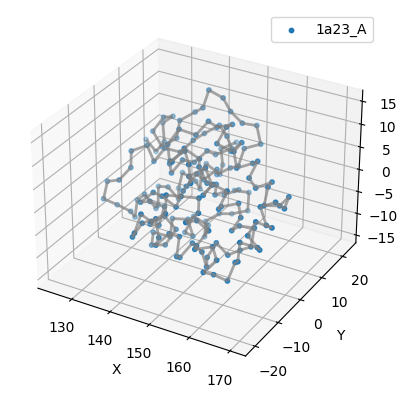

In [ ]:
# plotitng the C-alpha atoms to have a better shape an representation for the proteins.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from Bio.PDB import PDBParser

def extract_ca_coordinates(pdb_folder, pdb_name):
    parser = PDBParser(QUIET=True)
    ca_coordinates = {}

    pdb_file = f"{pdb_name}.pdb"
    file_path = os.path.join(pdb_folder, pdb_file)
    structure = parser.get_structure(pdb_name, file_path)

    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[0] == " " and residue.has_id("CA"):  # Check for C-alpha atom
                    res_id = residue.id[1]
                    ca_coord = residue['CA'].get_coord()
                    ca_coordinates[res_id] = ca_coord

    return ca_coordinates

def plot_protein_ca_with_lines(ca_coordinates, pdb_name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x_coords, y_coords, z_coords = [], [], []

    for res_id, coordinates in ca_coordinates.items():
        x, y, z = coordinates
        x_coords.append(x)
        y_coords.append(y)
        z_coords.append(z)

    ax.scatter(x_coords, y_coords, z_coords, label=pdb_name, s=10)

    lines = [[(x_coords[i], y_coords[i], z_coords[i]), (x_coords[i+1], y_coords[i+1], z_coords[i+1])] for i in range(len(x_coords)-1)]
    lc = Line3DCollection(lines, linewidths=2.0, colors='grey', alpha=0.7)
    ax.add_collection3d(lc)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Replace with the folder containing your PDB files
pdb_folder = "/content/drive/MyDrive/outputPDB"

# Example usage:
protein_name = input("Enter the protein name (without .pdb extension): ")
ca_coordinates = extract_ca_coordinates(pdb_folder, protein_name)
plot_protein_ca_with_lines(ca_coordinates, protein_name)


# The next blocks of codes arent necessry, havent check them, dont trust them!!!!

# backbone coordinates extraction: C, CA, N

In [ ]:
import os
import json
from Bio.PDB import PDBParser

def extract_backbone_coordinates(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)

    backbone_coordinates = {}
    for model in structure:
        for chain in model:
            chain_id = chain.get_id()
            backbone_coordinates[chain_id] = {}

            for residue in chain:
                if residue.get_id()[0] != " " or residue.get_resname() == "HOH":
                    continue

                residue_id = residue.get_id()[1]
                backbone = residue.get_unpacked_list()[0:3]  # N, CA, C atoms
                backbone_coordinates[chain_id][residue_id] = [list(atom.get_vector()) for atom in backbone]

    return backbone_coordinates

def process_pdb_folder(folder_path):
    pdb_files = [f for f in os.listdir(folder_path) if f.endswith('.pdb')]
    pdb_data = {}

    for pdb_file in pdb_files:
        pdb_path = os.path.join(folder_path, pdb_file)
        pdb_name = os.path.splitext(pdb_file)[0]
        pdb_data[pdb_name] = extract_backbone_coordinates(pdb_path)

    return pdb_data

def save_json(data, output_file):
    with open(output_file, 'w') as json_file:
        json.dump(data, json_file, indent=4)


In [ ]:
if __name__ == "__main__":
    pdb_folder_path = "/content/drive/MyDrive/outputPDB"
    # name of the file
    output_json_file = "output.json"

    extracted_data = process_pdb_folder(pdb_folder_path)
    save_json(extracted_data, output_json_file)


In [ ]:
"""from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import protein_letters_3to1

def extract_backbone_coordinates(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)

    backbone_coordinates = {}
    for model in structure:
        for chain in model:
            chain_id = chain.get_id()
            backbone_coordinates[chain_id] = []

            for residue in chain:
                if residue.get_id()[0] != " " or residue.get_resname() == "HOH":
                    continue

                amino_acid_name = residue.get_resname()

                # Convert three-letter code to one-letter code
                if amino_acid_name in protein_letters_3to1:
                    one_letter_code = protein_letters_3to1[amino_acid_name]
                    backbone_coordinates[chain_id].append(one_letter_code)

    return backbone_coordinates

# Rest of your code

if __name__ == "__main__":
    pdb_folder_path = "/content/drive/MyDrive/NewPDBFiles"
    output_json_file = "output.json"

    extracted_data = process_pdb_folder(pdb_folder_path)
    save_json(extracted_data, output_json_file)

"""

# plot the backbone

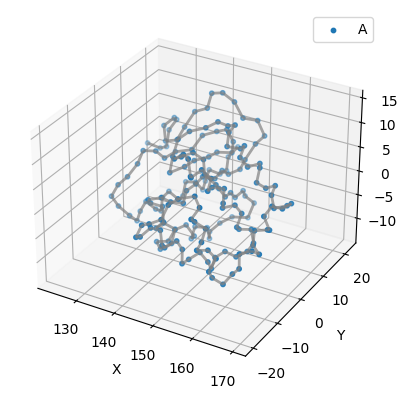

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_protein_backbone_with_lines(backbone_coordinates):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for chain_id, residue_data in backbone_coordinates.items():
        x_coords, y_coords, z_coords = [], [], []
        atom_sequence = []

        for residue_id, coordinates in residue_data.items():
            x, y, z = coordinates[0]  # Take the x, y, z coordinates from the first atom (N atom)
            x_coords.append(x)
            y_coords.append(y)
            z_coords.append(z)

            atom_sequence.append(coordinates)

        ax.scatter(x_coords, y_coords, z_coords, label=chain_id, s=10)  # Set the size of dots with the 's' parameter

        # Connect neighboring atoms with lines in the correct order
        lines = [[atom_sequence[i][0], atom_sequence[i+1][0]] for i in range(len(atom_sequence)-1)]
        lc = Line3DCollection(lines, linewidths=2.0, colors='grey', alpha=0.7)  # Set the thickness of lines with 'linewidths'
        ax.add_collection3d(lc)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Example usage:
pdb_file = "1a23_A"  # Replace with the specific PDB file you want to plot
backbone_coordinates = extracted_data[pdb_file]
plot_protein_backbone_with_lines(backbone_coordinates)
